# Team 5 : NeoMusic

Team members

1) Anuj Sharma

2) Sandhya Santhanam

3) Suriya Palanikumar

NeoMusic is to recommend similar music artists addressing the cold-start issue without usage data(Ratings/Similarity).

**Steps Followed:**

1) Nearst neighbors of each artists has been found with clustering techniques.

2) Distance of each artists has been computed with their neighboring artists using Non-Symmetric distance metric(Hausdorff distance).

3) The distance metric has been imported to Neo4j to find the similar artist using Graph mining techniques. Single source shortest path has been used to recommend the top-k similar artists.  (Queries are included in the notebook).

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!pip install k-means-constrained
!pip install yellowbrick

  Using cached numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
k-means-constrained 0.6.0 requires numpy>=1.20.3, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [84]:
import pandas as pd
import numpy as np
from k_means_constrained import KMeansConstrained
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/256_Project/deezer_features.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,1,-0.007510,0.002892,0.006003,-0.008288,0.001388,-0.009587,-0.002597,-0.001651,0.007500,0.005377,-0.014132,0.024988,0.000546,-0.010660,-0.017597,0.006302,0.023571,-0.013865,0.005722,-0.030666,-0.003915,0.054639,-0.036781,0.018083,-0.004836,-0.001371,-0.018559,0.026180,0.011409,-0.026717,0.009286,-0.029503,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.459391,0.193252,0.139495,0.151400
1,2,-0.172181,-0.082732,0.135843,0.011548,0.017318,-0.254997,0.113355,0.033932,-0.071162,-0.099428,-0.107563,0.042243,0.106874,-0.127894,-0.018735,0.017060,0.076911,-0.127784,-0.183286,-0.182893,0.120741,-0.158713,-0.077712,0.008842,-0.133573,0.030468,-0.225340,0.060964,0.047286,0.195375,0.066941,-0.076980,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333660,0.161552,0.120748,0.167415
2,3,-0.157183,0.009618,0.088339,-0.084143,0.094306,-0.351647,-0.034583,0.144340,-0.008939,-0.219161,-0.052356,0.286848,0.198618,-0.214440,-0.268811,0.150304,0.448504,-0.384054,0.057444,-0.138773,0.220159,0.288947,-0.352348,-0.050004,0.051974,0.038191,-0.202896,0.417181,0.010661,0.114940,0.244948,0.222384,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.153438,0.186358,0.148314,0.113224
3,4,-0.124824,-0.020829,0.109950,0.005343,-0.014215,-0.075313,-0.015466,0.142181,0.093969,0.049267,-0.040896,-0.058768,0.015671,0.000444,0.055295,-0.003689,0.235109,-0.218155,0.120014,-0.146563,0.243076,-0.017480,-0.035989,0.017321,-0.189579,0.234798,-0.151922,0.161062,-0.054403,0.262250,0.217358,0.176144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.606095,0.376574,0.045419,0.033385
4,5,-0.261996,-0.288156,0.197021,-0.208817,1.027182,0.207817,-0.073727,0.010425,-0.029520,0.173434,0.076610,-0.029162,-0.006886,0.002491,0.105421,0.066087,-0.081108,0.155968,0.103546,-0.086449,-0.114413,-0.202190,-0.498856,-0.183288,0.200243,0.339281,0.049975,-0.064397,-0.205344,-0.324963,0.335434,-0.181493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.206979,0.045804,0.141537,0.142070


# Approach 1 : K Means Clustering

In [5]:
km = KMeans()
k = list(range(90, 160, 10))
k

[90, 100, 110, 120, 130, 140, 150]

/usr/local/lib/python3.7/dist-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.7/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


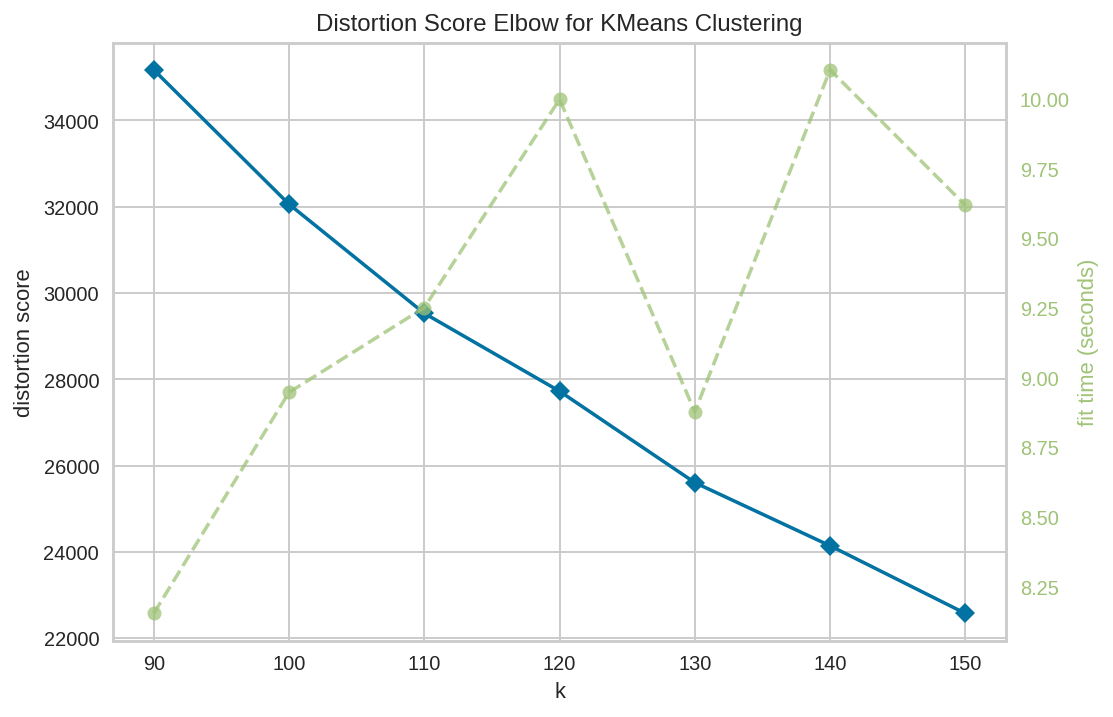

In [6]:
# Elbow Method to find the optimal K
viz = KElbowVisualizer(km, k=k)
viz.fit(df.iloc[:,1:])
viz.show()

In [8]:
kmeans = KMeans(n_clusters= 122)
kmeans.fit(df.iloc[:,1:])

KMeans(n_clusters=122)

In [9]:
len(kmeans.cluster_centers_)

122

In [11]:
cluster_map = pd.DataFrame()
cluster_map['artistID'] = df[0].values
cluster_map['clusterLabel'] = kmeans.labels_
cluster_map.head(10)

,artistID,clusterLabel
0,1,111
1,2,37
2,3,32
3,4,80
4,5,31
5,6,111
6,7,104
7,8,111
8,9,104
9,10,111


In [118]:
d = {}
for i in range(len(kmeans.labels_)):
  d[i] = cluster_map[cluster_map.clusterLabel == i]["artistID"].values.tolist()

In [27]:
# Finding the index of the minimum data points in a cluster
findmin = float("inf")
index = float("inf")
for i in range(122):
  if(len(d[i])<findmin):
    findmin = len(d[i])
    index = i
print("Minimum data Points of a cluster :", findmin)
print("Index of minimum data points in a cluster :", index)

Minimum data Points of a cluster : 3
Index of minimum data points in a cluster : 89


In [28]:
# Finding the index of maximum data points in a cluster
findmax = float("-inf")
index = float("-inf")
for i in range(122):
  if(len(d[i])>findmax):
    findmax = len(d[i])
    index = i
print("Maximum data Points of a cluster :", findmax)
print("Index of maximum data points in a cluster :", index)

Maximum data Points of a cluster : 2382
Index of maximum data points in a cluster : 1


**Comments**

Implementing K-Means clustering to group similar artists produce cluster of different sizes. We could see that minimum data points in a cluster is 3 and maximum data points is 2382. This may result in a scenario where the artist of smaller cluster may not get recommended. This may again result in Cold-Start problem. Hence ignored this approach.

# Approach 2: KMeans Constrained

**Algorithm 1: Clustering the data points using KMeans Constrained** 

In [97]:
kmeans = KMeansConstrained(122, size_min=20, size_max=200, random_state=2, verbose=True,)

In [98]:
resfit = kmeans.fit(df.iloc[:,1:])

Initialization complete
Iteration  0, inertia 931815.856
Iteration  1, inertia 120174.322
Iteration  2, inertia 88918.419
Iteration  3, inertia 85453.437
Iteration  4, inertia 83977.944
Iteration  5, inertia 82539.608
Iteration  6, inertia 81299.223
Iteration  7, inertia 80909.879
Iteration  8, inertia 80650.950
Iteration  9, inertia 80025.884
Iteration 10, inertia 79374.982
Iteration 11, inertia 79223.101
Iteration 12, inertia 79083.807
Iteration 13, inertia 79015.940
Iteration 14, inertia 79009.101
Iteration 15, inertia 79007.822
Iteration 16, inertia 79005.037
Iteration 17, inertia 79004.427
Iteration 18, inertia 79003.899
Iteration 19, inertia 79004.015
Iteration 20, inertia 79004.316
Iteration 21, inertia 79004.715
Iteration 22, inertia 79004.899
Iteration 23, inertia 79004.919
Iteration 24, inertia 79004.878
Iteration 25, inertia 79004.846
Iteration 26, inertia 79004.880
Iteration 27, inertia 79004.845
Converged at iteration 27: center shift 4.878133e-05 within tolerance 7.044287

In [85]:
print(len(kmeans.cluster_centers_))
print(kmeans.labels_)

122
[10 37 27 ... 23 72 48]


In [64]:
cluster_map = pd.DataFrame()
cluster_map['artistID'] = df[0].values
cluster_map['clusterLabel'] = kmeans.labels_

In [65]:
cluster_map

,artistID,clusterLabel
0,1,10
1,2,37
2,3,27
3,4,36
4,5,40
...,...,...
24265,24266,20
24266,24267,28
24267,24268,23
24268,24269,72


In [66]:
# COnverting all the clusters into a dataframe
d = {}
for i in range(len(kmeans.cluster_centers_)):
  d[i] = cluster_map[cluster_map.clusterLabel == i]["artistID"].values.tolist()

In [67]:
# Finding the index of the minimum data points in a cluster
findmin = float("inf")
index = float("inf")
for i in range(122):
  if(len(d[i])<findmin):
    findmin = len(d[i])
    index = i
print("Minimum data Points of a cluster :", findmin)
print("Index of minimum data points in a cluster :", index)

Minimum data Points of a cluster : 143
Index of minimum data points in a cluster : 21


In [68]:
# Finding the index of maximum data points in a cluster
findmax = float("-inf")
index = float("-inf")
for i in range(122):
  if(len(d[i])>findmax):
    findmax = len(d[i])
    index = i
print("Maximum data Points of a cluster :", findmax)
print("Index of maximum data points in a cluster :", index)

Maximum data Points of a cluster : 200
Index of maximum data points in a cluster : 0


**Comments**

KMeans constrained almost produces same number of data points in each clusters. It may help us to overcome the cold-start problem.

In [69]:
df_copy = df
df_copy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
0,1,-0.007510,0.002892,0.006003,-0.008288,0.001388,-0.009587,-0.002597,-0.001651,0.007500,0.005377,-0.014132,0.024988,0.000546,-0.010660,-0.017597,0.006302,0.023571,-0.013865,0.005722,-0.030666,-0.003915,0.054639,-0.036781,0.018083,-0.004836,-0.001371,-0.018559,0.026180,0.011409,-0.026717,0.009286,-0.029503,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.459391,0.193252,0.139495,0.151400
1,2,-0.172181,-0.082732,0.135843,0.011548,0.017318,-0.254997,0.113355,0.033932,-0.071162,-0.099428,-0.107563,0.042243,0.106874,-0.127894,-0.018735,0.017060,0.076911,-0.127784,-0.183286,-0.182893,0.120741,-0.158713,-0.077712,0.008842,-0.133573,0.030468,-0.225340,0.060964,0.047286,0.195375,0.066941,-0.076980,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.333660,0.161552,0.120748,0.167415
2,3,-0.157183,0.009618,0.088339,-0.084143,0.094306,-0.351647,-0.034583,0.144340,-0.008939,-0.219161,-0.052356,0.286848,0.198618,-0.214440,-0.268811,0.150304,0.448504,-0.384054,0.057444,-0.138773,0.220159,0.288947,-0.352348,-0.050004,0.051974,0.038191,-0.202896,0.417181,0.010661,0.114940,0.244948,0.222384,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.153438,0.186358,0.148314,0.113224
3,4,-0.124824,-0.020829,0.109950,0.005343,-0.014215,-0.075313,-0.015466,0.142181,0.093969,0.049267,-0.040896,-0.058768,0.015671,0.000444,0.055295,-0.003689,0.235109,-0.218155,0.120014,-0.146563,0.243076,-0.017480,-0.035989,0.017321,-0.189579,0.234798,-0.151922,0.161062,-0.054403,0.262250,0.217358,0.176144,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.606095,0.376574,0.045419,0.033385
4,5,-0.261996,-0.288156,0.197021,-0.208817,1.027182,0.207817,-0.073727,0.010425,-0.029520,0.173434,0.076610,-0.029162,-0.006886,0.002491,0.105421,0.066087,-0.081108,0.155968,0.103546,-0.086449,-0.114413,-0.202190,-0.498856,-0.183288,0.200243,0.339281,0.049975,-0.064397,-0.205344,-0.324963,0.335434,-0.181493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.206979,0.045804,0.141537,0.142070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24265,24266,-0.010896,0.004925,0.007012,-0.011154,0.000564,-0.010630,-0.005717,-0.001522,0.008626,0.014121,-0.019016,0.037802,-0.001078,-0.013989,-0.018770,0.008523,0.034514,-0.017024,0.005374,-0.046948,-0.003899,0.079196,-0.053429,0.020552,-0.002427,-0.002476,-0.025327,0.034288,0.014308,-0.033501,0.008387,-0.038547,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
24266,24267,-2.731792,-0.959017,1.253861,-6.583517,-1.504298,0.022879,0.196071,-0.032315,-0.982337,-1.450639,0.279417,0.566180,-0.714064,-0.577180,0.096931,-0.477940,0.703578,-0.587980,1.288119,0.614030,0.518917,-0.745404,0.007736,0.971479,-0.145516,-0.018189,0.606251,-1.416552,0.598602,0.735568,0.776244,-1.247025,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.565893,0.307838,0.024954,0.060579
24267,24268,-7.198960,10.708150,0.430730,1.046649,1.454021,0.975385,1.383204,-1.660526,0.271799,-1.190920,0.372417,-0.687531,0.173958,0.583410,-0.282779,-0.153792,0.050191,-0.640269,0.460688,0.003904,-0.433184,-0.328148,-0.073391,-0.399192,0.042157,-0.445394,-0.309775,0.335697,0.058461,0.097435,-0.864148,-0.488758,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.293801,0.371082,0.073013,0.107677
24268,24269,-0.124824,-0.020829,0.109950,0.005343,-0.014215,-0.075313,-0.015466,0.142181,0.093969,0.049267,-0.040896,-0.058768,0.015671,0.000444,0.055295,-0.003689,0.235109,-0.218155,0.120014,-0.146563,0.243076,-0.017480,-0.035989,0.017321,-0.189579,0.234798,-0.151922,0.161062,-0.054403,0.262250,0.217358,0.176144,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000


**Algorithm 2: Hausdorff distance calculation**



In [ ]:
##calculating hausdoff distance for each data points of each clusters
from scipy.spatial.distance import directed_hausdorff

ddict = {'sartist':[],
        'dartist':[],
        'distance':[]
       }
  
ddf = pd.DataFrame(ddict)
count = 0

for i in range(10):
  for j in d[i]:
    #print(len(d[i]))
    count = count+1
    #print(count)
    for k in d[i]:
      if(j!=k):
        u = np.array(df[df[0]==j].drop([0], axis=1))
        v = np.array(df[df[0]==k].drop([0], axis=1))
        ddf.loc[len(ddf.index)] = [j, k, directed_hausdorff(u,v)[0]]

In [42]:
ddf["sartist"] = ddf["sartist"].astype(int)
ddf["dartist"] = ddf["dartist"].astype(int)

In [74]:
s = "CREATE "
for i in list(ddf["sartist"].unique()):
  #print(i)
  s = s+"(artist"+str(i)+":ARTIST{name:'artist"+str(int(i))+"'})"
  # if(i<24269):
  s=s+","

In [75]:
d = ""
for k in len(d):
  for i in k:
    d = d+"(artist"+str(int(ddf.iloc[i]["sartist"]))+")-[:CONNECTED{cost:"+str(ddf.iloc[i]["distance"].round(4))+"}]->(artist"+str(int(ddf.iloc[i]["dartist"]))+")"
    if(i<len(k)-1):
      d = d+","
    else:
      d = d+";"

In [76]:
s = s+d
text_file = open("custerfull.cypher", "w")
n = text_file.write(s)
text_file.close()

**Comments:**


The idea is that distance between two artists need not to be symmetric. ie., d(A,B) need not to be equal to d(B,A). Hence calculated the Hausdorff distance(non-symmetric) between all points in a cluster.

**Algorithm:Single Source Shortest Path**

In [ ]:
# For loading the cypher query
# bin\cypher-shell.bat -f custer.cypher

In [ ]:
# Single source Shortest Path Parameter setting which defines the top-k recommended artists



# :param limit => ( 10);
# :param config => ({
#   nodeProjection: 'ARTIST',
#   relationshipProjection: {
#     relType: {
#       type: 'CONNECTED',
#       orientation: 'NATURAL',
#       properties: {
#         cost: {
#           property: 'cost',
#           defaultValue: 1
#         }
#       }
#     }
#   },
#   relationshipWeightProperty: 'cost'
# });
# :param startNode => ('artist1617');
# :param endNode => (null);
# :param communityNodeLimit => ( 10);

In [ ]:
# SSSp Algorithm implementation

# CALL db.propertyKeys() YIELD propertyKey MATCH (start) WHERE start[propertyKey] contains $startNode
# WITH start
# LIMIT 1
# WITH $config AS config, start
# WITH config { .*, sourceNode: id(start)} as config
# CALL gds.allShortestPaths.dijkstra.stream(config)
# YIELD targetNode AS nodeId, totalCost AS cost
# RETURN gds.util.asNode(nodeId) AS node, cost
# LIMIT toInteger($limit)

#Evaluations

**Evaluation Num:1**

Since the ground truths are unknown, Davies Bouldin score is used to evaluate the KMeans Constrained clustering.

In [130]:
print("Davies Bouldin Score : ",davies_bouldin_score(df.iloc[:,1:], kmeans.labels_).round(2))

Davies Bouldin Score :  0.77


Comments:

Provided the densely connected network, davies_bouldin_score of 0.77 seems to be a better score.


1) Dataset separation is not so clear. For example: Genres in the dataset are not clearly separated. ie., a 'rock' genre song might also contains some elements of other genre like 'metal'.


2) If the clusters become more sparse, there could be a potential cold-start problem in the network. Hence, among the various values, k-value of 122 gave the better result.

**Evaluation Num:2**

In [ ]:
f = kmeans.predict(df.iloc[:,1:])

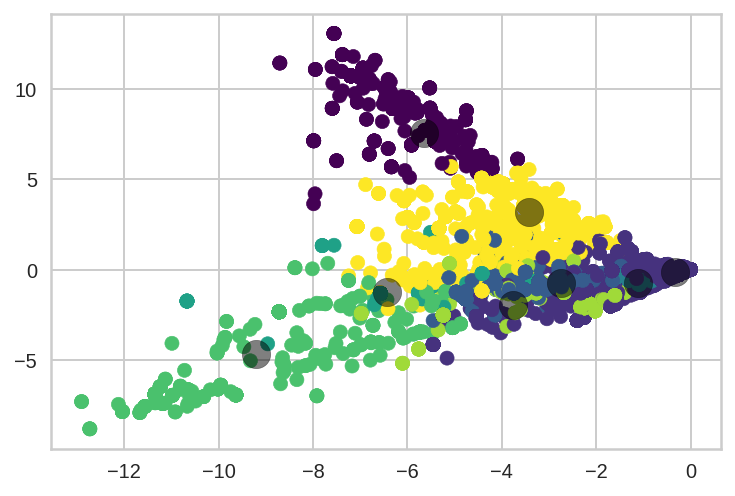

In [126]:
plt.scatter(df.iloc[:,1:][1],df.iloc[:,1:][2], c=f, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Comments:

From the graph we can see that the data points are densely connected to form clusters.

We can also see that the clusters are separated compatively well to find the nearest neighbours.So, our KMeans constrained algorithm with k=122  works well.

**Empirical Method:3**

In [140]:
import math
print("Emperical technique: ",math.sqrt(df.shape[0]/2))

Emperical technique:  110.15897603009934


Comments:

Empirical technique is a basic evaluation methodology to determine k. Here, we could see that with empirical technique we got the k value as 110 which is an approximation of the K-value we have used. 
